In [27]:
#installations
!pip install seaborn
!pip install statsmodels
!pip install pmdarima
!pip install shap
#imports
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import pmdarima as pm
from pmdarima import model_selection
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [29]:
#read the txt file and convert to a dataframe
with open('train_FD001.txt', 'r') as file:
    lines = file.readlines()
index_names = ['unit_num', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names
data = [line.strip().split(' ') for line in lines]
df = pd.DataFrame(data,columns=col_names)
df = df.astype(float)
#group it by unit number
grouped = df.groupby('unit_num')

In [30]:
#calculate the RUL column - max cycle time reached by the engine minus the current cycle
RUL = []
for group_name, group_data in grouped:
    for itr in range(len(group_data)):
        RUL.append(len(group_data) - int(group_data['time_cycles'].iloc[itr]))
df['RUL'] = RUL
df.to_csv('CSV_train.csv', index=False)

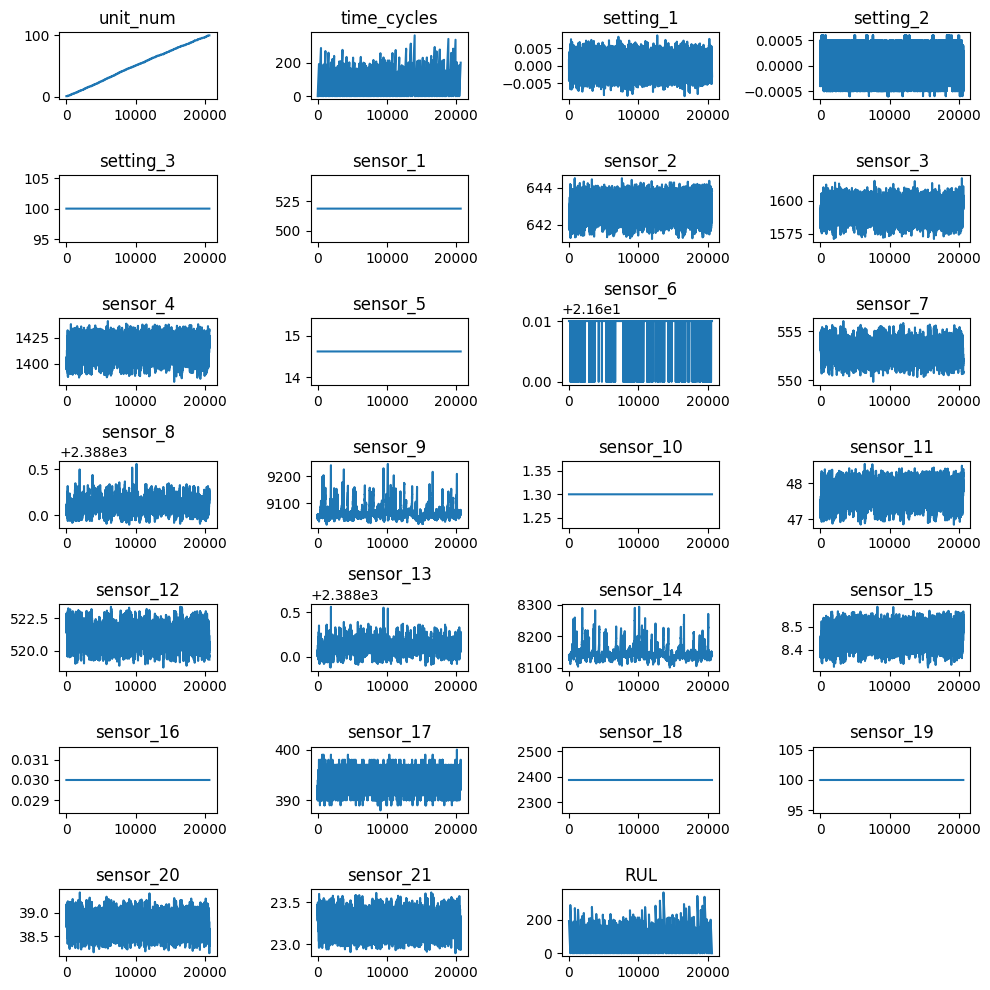

In [31]:
#plot all the timeseries variables just to see the trends
fig, axes = plt.subplots(7, 4, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    if i < len(df.columns):
        column = df.columns[i]
        ax.plot(df.index, df[column])
        ax.set_title(column)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [32]:
result_data = [['Column Name', 'Mean', 'Standard Deviation']]
for column_name in df.columns[2:-1]:
    column_mean = np.mean(df[column_name])
    column_std = np.std(df[column_name])
    result_data.append([column_name, column_mean, column_std])

table = tabulate(result_data, headers='firstrow', tablefmt='simple')
print(table)

Column Name              Mean    Standard Deviation
-------------  --------------  --------------------
setting_1        -8.87015e-06           0.00218726
setting_2         2.35083e-06           0.000293055
setting_3       100                     0
sensor_1        518.67                  0
sensor_2        642.681                 0.500041
sensor_3       1590.52                  6.131
sensor_4       1408.93                  9.00039
sensor_5         14.62                  1.77636e-15
sensor_6         21.6098                0.00138895
sensor_7        553.368                 0.885071
sensor_8       2388.1                   0.0709838
sensor_9       9065.24                 22.0823
sensor_10         1.3                   0
sensor_11        47.5412                0.267081
sensor_12       521.413                 0.737536
sensor_13      2388.1                   0.0719172
sensor_14      8143.75                 19.0757
sensor_15         8.44215               0.0375041
sensor_16         0.03        

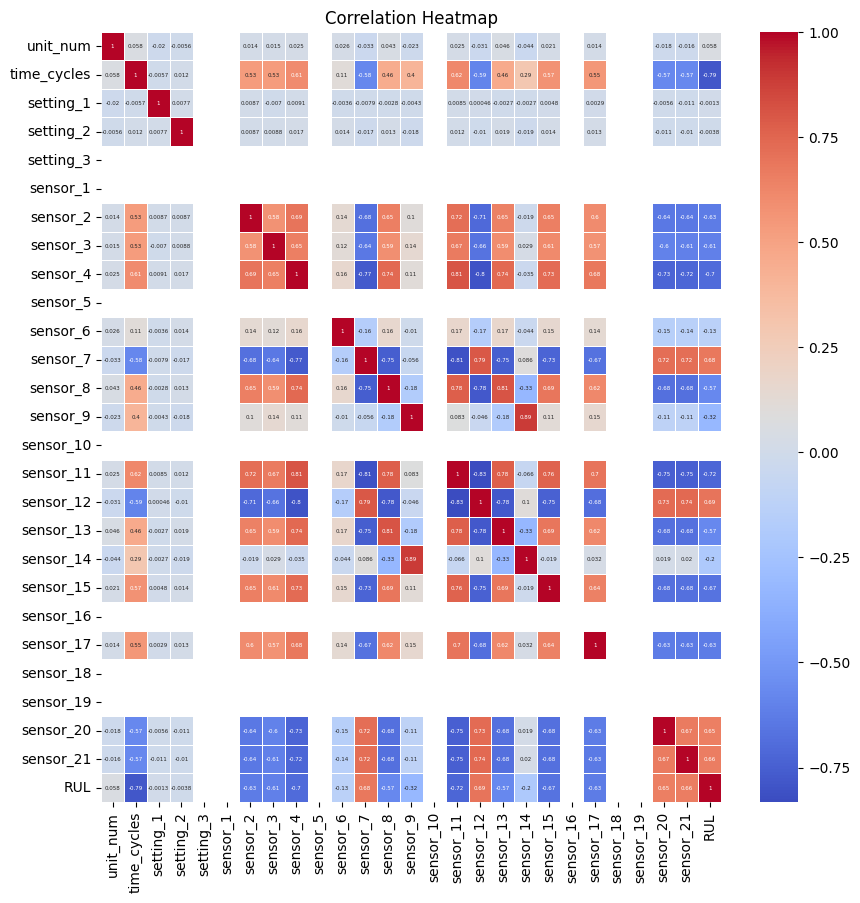

In [33]:
correlation_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.4, annot_kws={'fontsize': 4})
plt.title('Correlation Heatmap')
plt.show()

In [34]:
std_dev = df.std()
columns_to_keep = std_dev[std_dev > 0.00001].index
df_filtered = df[columns_to_keep]

In [35]:
result = [['Column Name','p-value']]
for columns in df_filtered.iloc[:, :-1]:
    max_lag = 1
    test_result = grangercausalitytests(df[['RUL',columns]], max_lag, verbose=True)
    p_value = test_result[1][0]['ssr_ftest'][1]
    result.append([columns,p_value])
table = tabulate(result, headers='firstrow', tablefmt='simple')
print(table)

/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packa


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0741  , p=0.3000  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=1.0743  , p=0.3000  , df=1
likelihood ratio test: chi2=1.0743  , p=0.3000  , df=1
parameter F test:         F=1.0741  , p=0.3000  , df_denom=20627, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.7599 , p=0.0004  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=12.7617 , p=0.0004  , df=1
likelihood ratio test: chi2=12.7578 , p=0.0004  , df=1
parameter F test:         F=12.7599 , p=0.0004  , df_denom=20627, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1727  , p=0.6777  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=0.1727  , p=0.6777  , df=1
likelihood ratio test: chi2=0.1727  , p=0.6777  , df=1
parameter F test:         F=0.1727  , p=0.6777  , df_denom=20627, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4603  

/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packa

ssr based F test:         F=237.0749, p=0.0000  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=237.1094, p=0.0000  , df=1
likelihood ratio test: chi2=235.7572, p=0.0000  , df=1
parameter F test:         F=237.0749, p=0.0000  , df_denom=20627, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=269.0040, p=0.0000  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=269.0431, p=0.0000  , df=1
likelihood ratio test: chi2=267.3039, p=0.0000  , df=1
parameter F test:         F=269.0040, p=0.0000  , df_denom=20627, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=218.9372, p=0.0000  , df_denom=20627, df_num=1
ssr based chi2 test:   chi2=218.9691, p=0.0000  , df=1
likelihood ratio test: chi2=217.8151, p=0.0000  , df=1
parameter F test:         F=218.9372, p=0.0000  , df_denom=20627, df_num=1
Column Name        p-value
-------------  -----------
unit_num       0.300027
time_cycles    0.000354945
setting_1      0.677725

/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/run/determined/pythonuserbase/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [36]:
#remove the not needed columns
columns_to_remove = ['setting_1','setting_2','sensor_6']
df_filtered = df_filtered.drop(columns=columns_to_remove)

In [37]:
first_col = df_filtered.iloc[:, 0]
second_col = df_filtered.iloc[:, 1]
last_col = df_filtered.iloc[:, -1]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_filtered.iloc[:, 2:-1])
normalized_df = pd.DataFrame(normalized_data, columns=df_filtered.columns[2:-1])
final_df = pd.concat([first_col, second_col, normalized_df, last_col], axis=1)
print(final_df)

       unit_num  time_cycles  sensor_2  sensor_3  sensor_4  sensor_7   
0           1.0          1.0 -1.721725 -0.134255 -0.925936  1.121141  \
1           1.0          2.0 -1.061780  0.211528 -0.643726  0.431930   
2           1.0          3.0 -0.661813 -0.413166 -0.525953  1.008155   
3           1.0          4.0 -0.661813 -1.261314 -0.784831  1.222827   
4           1.0          5.0 -0.621816 -1.251528 -0.301518  0.714393   
...         ...          ...       ...       ...       ...       ...   
20626     100.0        196.0  1.618000  1.216258  2.188375 -2.189329   
20627     100.0        197.0  1.717992  2.279706  2.738351 -2.833345   
20628     100.0        198.0  1.478011  1.946971  2.138377 -2.742957   
20629     100.0        199.0  1.098043  2.403666  1.955051 -3.036719   
20630     100.0        200.0  2.337940  1.607712  2.578358 -2.912435   

       sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  sensor_14   
0     -0.516338 -0.862813  -0.266467   0.334262  -1.058890  -0

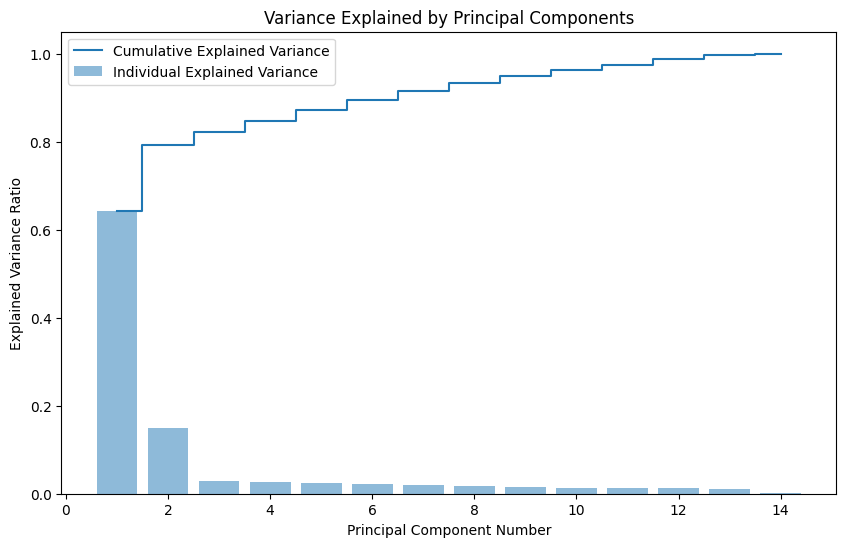

In [38]:
pca = PCA()
df_pca = pca.fit_transform(final_df.iloc[:,2:-1])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Principal Components')
plt.legend()
plt.show()

In [39]:
#elbow point
diffs = np.diff(explained_variance)*-1
print(max(diffs)*0.01)

0.00492795859855615


In [55]:
final_df

,unit_num,time_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1.0,1.0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,191
1,1.0,2.0,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,190
2,1.0,3.0,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,189
3,1.0,4.0,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,188
4,1.0,5.0,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,196.0,1.618000,1.216258,2.188375,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113,4
20627,100.0,197.0,1.717992,2.279706,2.738351,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764,3
20628,100.0,198.0,1.478011,1.946971,2.138377,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481,2
20629,100.0,199.0,1.098043,2.403666,1.955051,-3.036719,2.160330,0.383884,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072,1


In [40]:
#ramdomly pick 10 engine units and set those of training data
np.random.seed(42)
test_units = random.sample(range(1, 101), 10)
df_train = final_df[~final_df[final_df.columns[0]].isin(test_units)]
df_test = final_df[final_df[final_df.columns[0]].isin(test_units)]
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:,-1]

Mean Absolute Error Loss - Linear Regression: 27.17951690931234
Mean Squared Error Loss - Linear Regression: 27.17951690931234


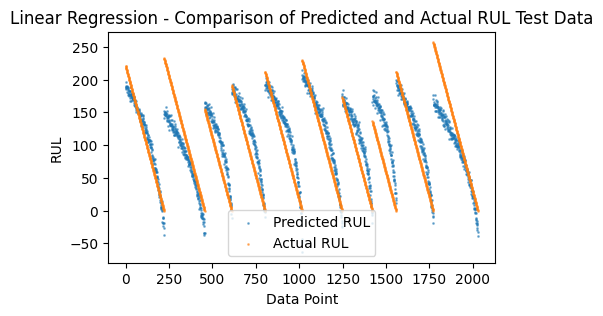

In [41]:
#Linear Regression
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
mae_LR = mean_absolute_error(y_test, y_pred_LR)
print('Mean Absolute Error Loss - Linear Regression:',mae_LR )
mse_LR = mean_squared_error(y_test, y_pred_LR)
print('Mean Squared Error Loss - Linear Regression:',mae_LR )
plt.figure(figsize=(5, 3))
x = list(range(len(y_pred_LR)))
plt.scatter(x, y_pred_LR, s=1, label='Predicted RUL', alpha=0.5)
plt.scatter(x, y_test, s=1, label='Actual RUL', alpha=0.5)
plt.legend()
plt.xlabel('Data Point')
plt.ylabel('RUL')
plt.title('Linear Regression - Comparison of Predicted and Actual RUL Test Data')
plt.show()

Mean Absolute Error Loss - Support Vector Regression: 26.112947682034115
Mean Squared Error Loss - Support Vector Regression: 1072.585819742108


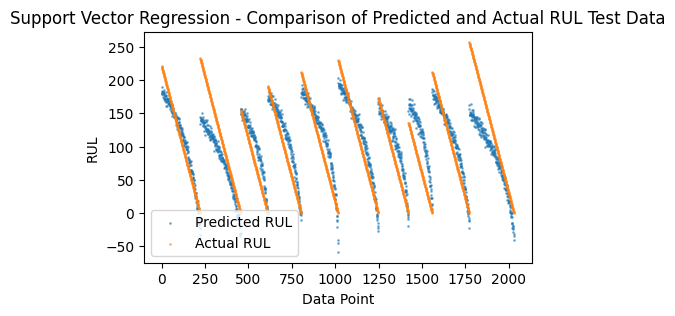

In [42]:
svr = SVR(kernel='linear', C= 1)
svr.fit(X_train, y_train)
y_pred_SVR = svr.predict(X_test)
mae_SVR = mean_absolute_error(y_test, y_pred_SVR)
print('Mean Absolute Error Loss - Support Vector Regression:',mae_SVR )
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
print('Mean Squared Error Loss - Support Vector Regression:',mse_SVR )
plt.figure(figsize=(5, 3))
x = list(range(len(y_pred_SVR)))
plt.scatter(x, y_pred_SVR, s=1, label='Predicted RUL', alpha=0.5)
plt.scatter(x, y_test, s=1, label='Actual RUL', alpha=0.5)
plt.legend()
plt.xlabel('Data Point')
plt.ylabel('RUL')
plt.title('Support Vector Regression - Comparison of Predicted and Actual RUL Test Data')
plt.show()

In [43]:
sequence_size = 30

X_train['RUL'] = y_train
grouped_train = X_train.groupby('unit_num')
lstm_xtrain = []
lstm_ytrain = []

for group_name, group_data in grouped_train:
    for itr in range(0,len(group_data)-sequence_size):
        lstm_xtrain.append(group_data.iloc[itr:itr+sequence_size,:-1].values)
        lstm_ytrain.append(group_data['RUL'].iloc[itr:itr+sequence_size].values)
lstm_xtrain = np.array(lstm_xtrain)
lstm_ytrain = np.array(lstm_ytrain)

X_test['RUL'] = y_test
grouped_test = X_test.groupby('unit_num')
lstm_xtest = []
lstm_ytest = []

for group_name, group_data in grouped_test:
    for itr in range(0,len(group_data)-sequence_size):
        lstm_xtest.append(group_data.iloc[itr:itr+sequence_size,:-1].values)
        lstm_ytest.append(group_data['RUL'].iloc[itr:itr+sequence_size].values)
lstm_xtest = np.array(lstm_xtest)
lstm_ytest = np.array(lstm_ytest)

In [44]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.x[index], self.y[index]

batch_size = 32

train_dataset = TimeSeriesDataset(lstm_xtrain, lstm_ytrain)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TimeSeriesDataset(lstm_xtest, lstm_ytest)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
input_size = 16
hidden_size_1 = 64
hidden_size_2 = 32
num_epochs = 100
learning_rate = 0.001
batch_size = 16
dropout_prob = 0.1
l2_weight = 0.001

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_size_2,dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm_1 = nn.LSTM(input_size, hidden_size_1, 1, batch_first=True,dropout=dropout_prob)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.lstm_2 = nn.LSTM(hidden_size_1, hidden_size_2, 1, batch_first=True,dropout=dropout_prob)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.fc = nn.Linear(hidden_size_2, 1)

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm_2(out)
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = out.permute(0, 2, 1)
        out = self.fc(out)
        return out

model = LSTMModel(input_size, hidden_size_1,hidden_size_2,dropout_prob)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [46]:
train_loss = []
evaluation_loss = []
# Training the model
for epoch in range(num_epochs):
    for x, y in (train_loader):
        outputs = model(x)[:,:,0]
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('Epoch =', epoch + 1)
    print('Loss on Train Data =', loss.item())
    train_loss.append(loss.item())
    
# Evaluation
    model.eval()
    with torch.no_grad():
        total_mse = 0
        for x, y in test_loader:
            outputs = model(x)[:,:,0]
            eval_loss = criterion(outputs, y).item()
            
    print('Loss on Test Data =', eval_loss)
    print('-------------------------------')
    evaluation_loss.append(eval_loss)

Epoch = 1
Loss on Train Data = 10844.7060546875
Loss on Test Data = 4069.738037109375
-------------------------------
Epoch = 2
Loss on Train Data = 819.3925170898438
Loss on Test Data = 141.4759979248047
-------------------------------
Epoch = 3
Loss on Train Data = 1349.2667236328125
Loss on Test Data = 47.98589324951172
-------------------------------
Epoch = 4
Loss on Train Data = 1268.10986328125
Loss on Test Data = 60.70884704589844
-------------------------------
Epoch = 5
Loss on Train Data = 1052.4803466796875
Loss on Test Data = 60.5567626953125
-------------------------------
Epoch = 6
Loss on Train Data = 1315.412841796875
Loss on Test Data = 78.7467041015625
-------------------------------
Epoch = 7
Loss on Train Data = 458.3821105957031
Loss on Test Data = 102.23970794677734
-------------------------------
Epoch = 8
Loss on Train Data = 739.2088623046875
Loss on Test Data = 67.94735717773438
-------------------------------
Epoch = 9
Loss on Train Data = 1157.068603515625


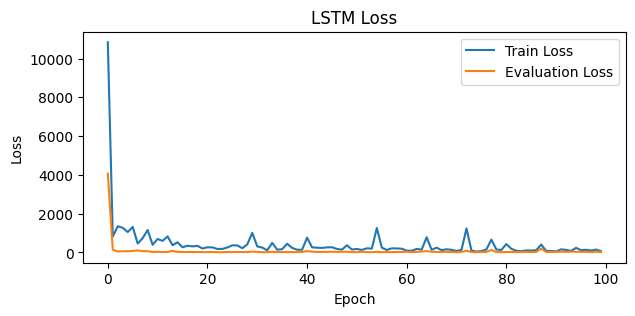

In [49]:
plt.figure(figsize=(7, 3))
x = list(range(len(train_loss)))
plt.plot(x, train_loss, label='Train Loss')
plt.plot(x, evaluation_loss, label='Evaluation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss')
plt.show()

Mean Absolute Error Loss - LSTM: 9.477273804892157


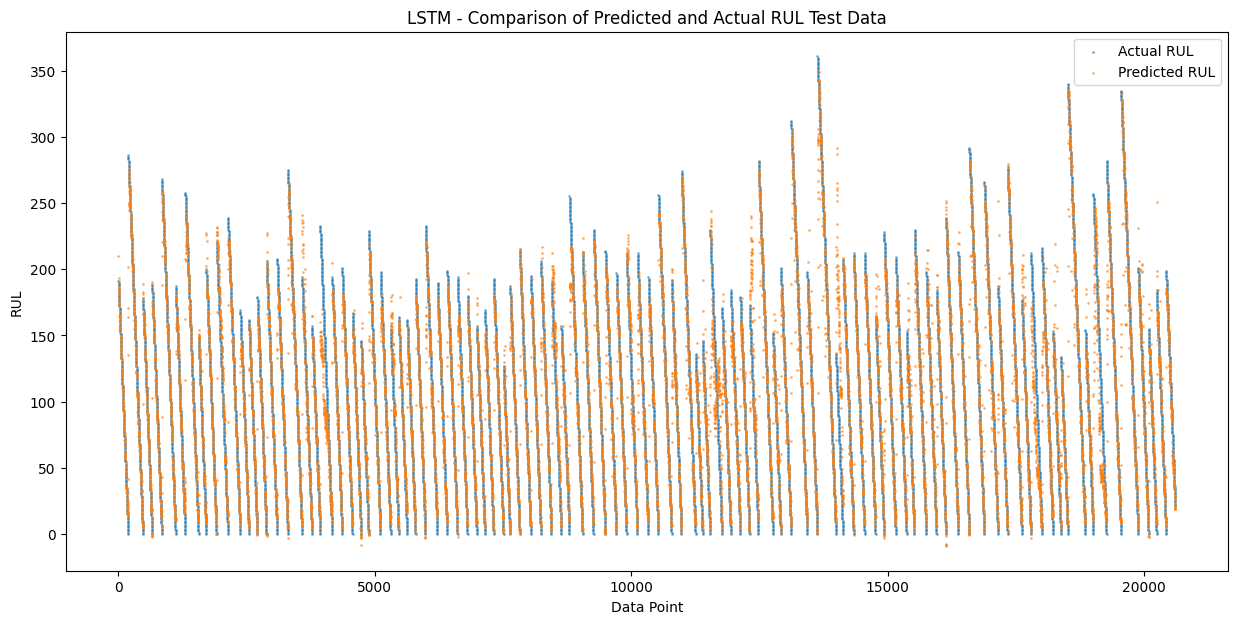

In [50]:
real_data = []
predicted_data = []
sequence_size = 30

for itr in range(0,len(final_df)-sequence_size,sequence_size):
    to_test = final_df.iloc[itr : itr + sequence_size,:-1].values
    real_data.extend(final_df['RUL'].iloc[itr : itr + sequence_size])
    to_test_tensor = torch.tensor(to_test, dtype=torch.float32)
    to_test_tensor = to_test_tensor.reshape(1,sequence_size,16)
    model.eval()
    with torch.no_grad():
        predicted_sequence = model(to_test_tensor)[:,:,0][0].numpy()
        predicted_data.extend(predicted_sequence)
        
mae_LSTM = mean_absolute_error(real_data, predicted_data)
print('Mean Absolute Error Loss - LSTM:',mae_LSTM )
        
plt.figure(figsize=(15, 7))
x = list(range(len(real_data)))
plt.scatter(x, real_data, s=1, label='Actual RUL', alpha=0.5)
plt.scatter(x, predicted_data, s=1, label='Predicted RUL', alpha=0.5)
plt.legend()
plt.xlabel('Data Point')
plt.ylabel('RUL')
plt.title('LSTM - Comparison of Predicted and Actual RUL Test Data')
plt.show()